# Evaluate the results from Syn-Boost

In [2]:
TDDPM_DIR = "/home/liu00980/Documents/syn/tab-ddpm"

import numpy as np
import pandas as pd
from sklearn.preprocessing import quantile_transform


import os
import json
import pickle

import matplotlib.pyplot as plt

from utils.sample import TrueSampler


import sys

sys.path.insert(0, os.path.join(TDDPM_DIR, "utils"))

from utils_syn import (
    concat_data,
    catboost_pred_model,
    test_rmse,
)

from utils_num import wasserstein_2_distance
from utils_viz import compare_distributions_grid, heatmap_correlation

## Evaluate generation quality of pre-trained model

In [3]:
# Specify the configuration (pre-training size) of the model to be evaluated
n_pretrain = 5000

keyword = f"reg_{n_pretrain}"
pretrain_data_dir = os.path.join(TDDPM_DIR, f"data/reg_{n_pretrain}")
synthetic_sample_dir = f"./ckpt/{keyword}"


In [4]:
# Load pre-training data and generated synthetic data after excecuting train.py
true_df = concat_data(pretrain_data_dir, split="train")
synthetic_df = concat_data(synthetic_sample_dir, split="train")

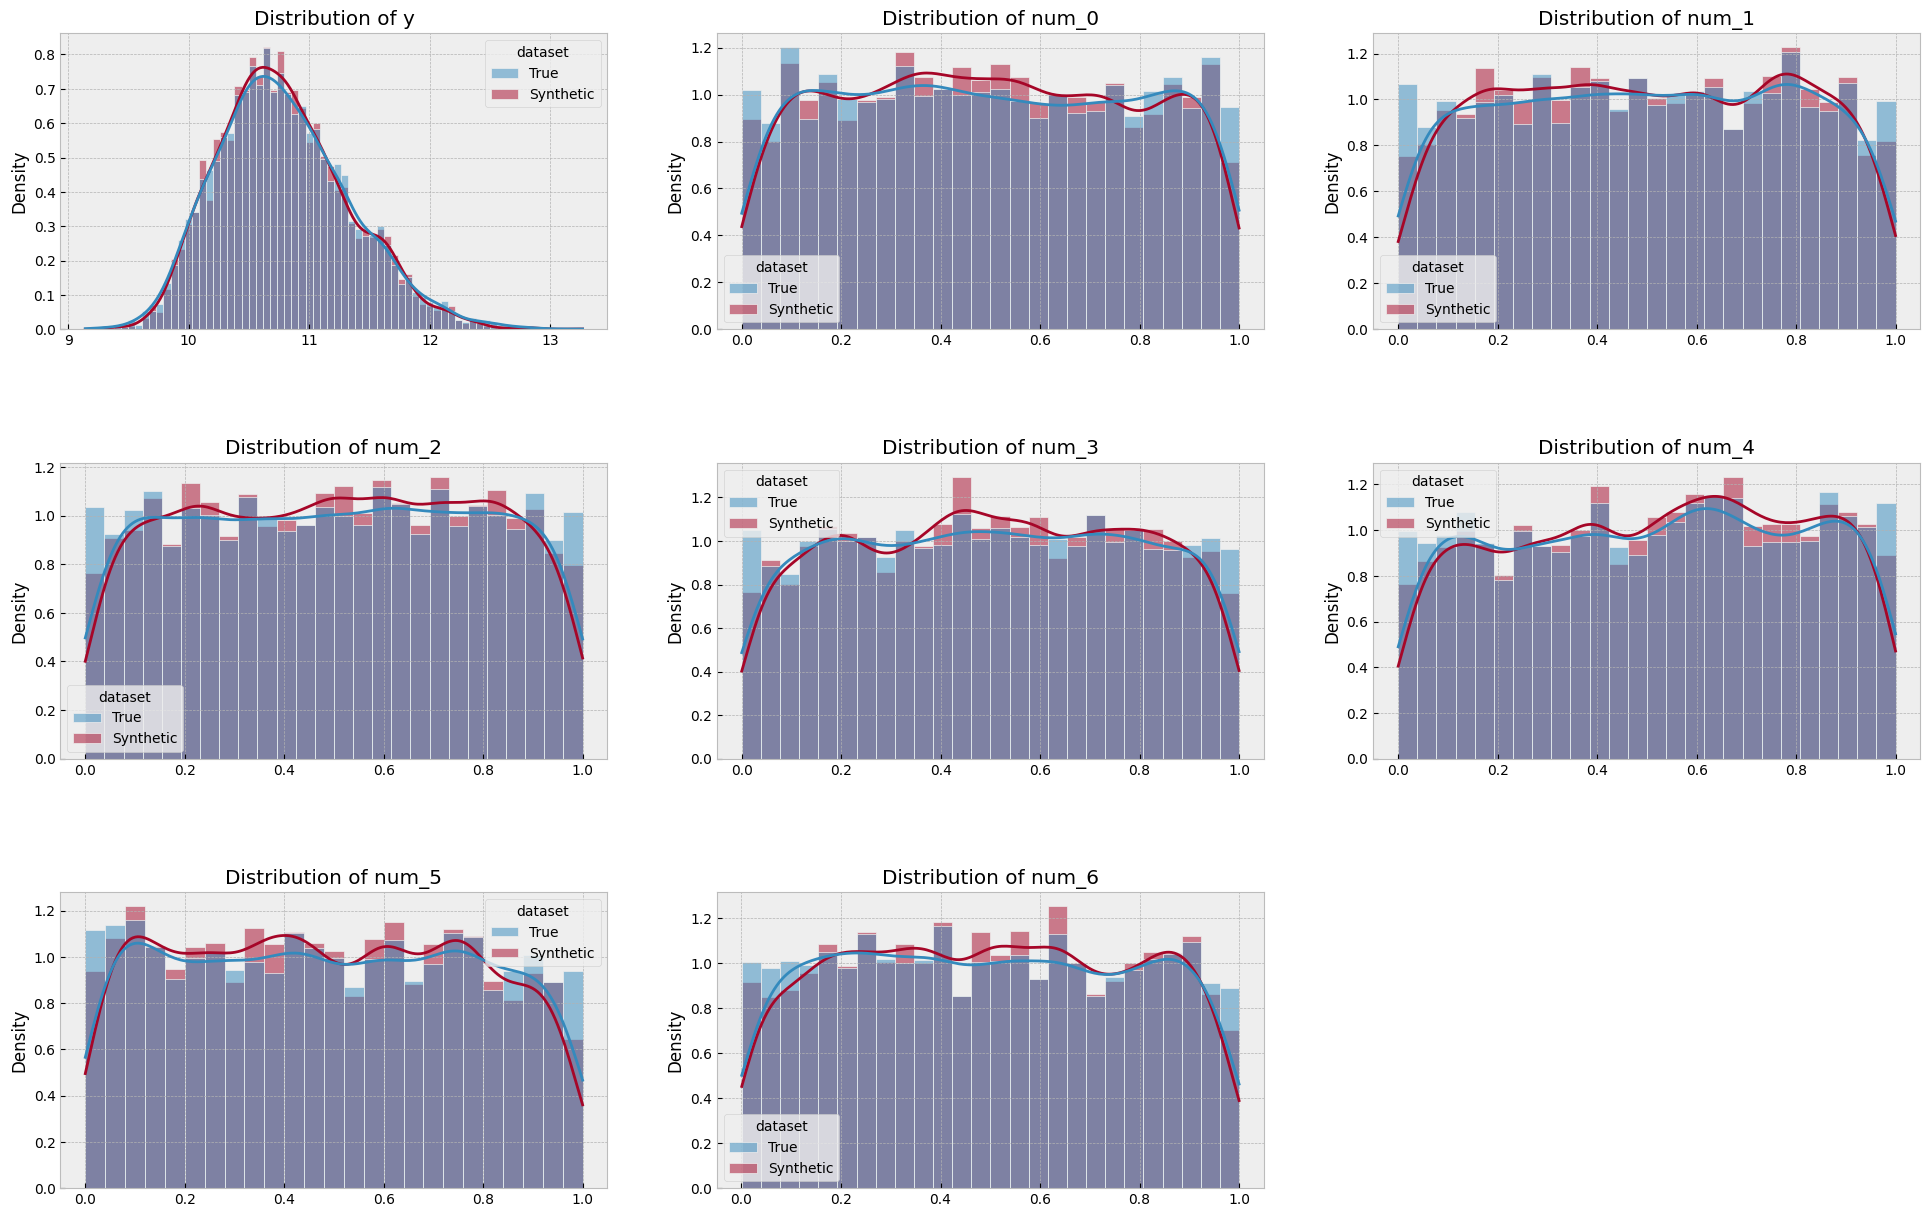

In [5]:
compare_distributions_grid([true_df, synthetic_df], ["True", "Synthetic"], 3, 3)

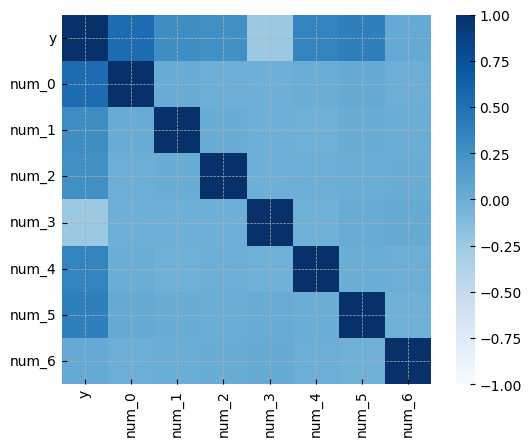

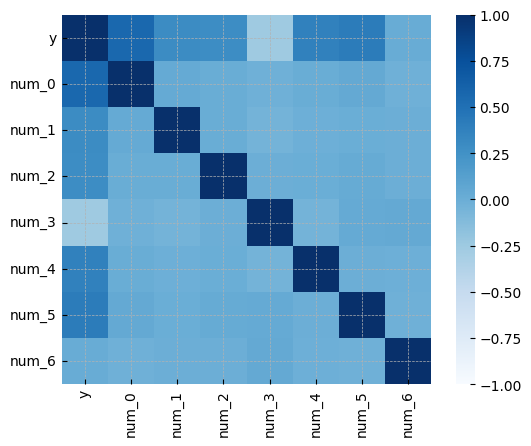

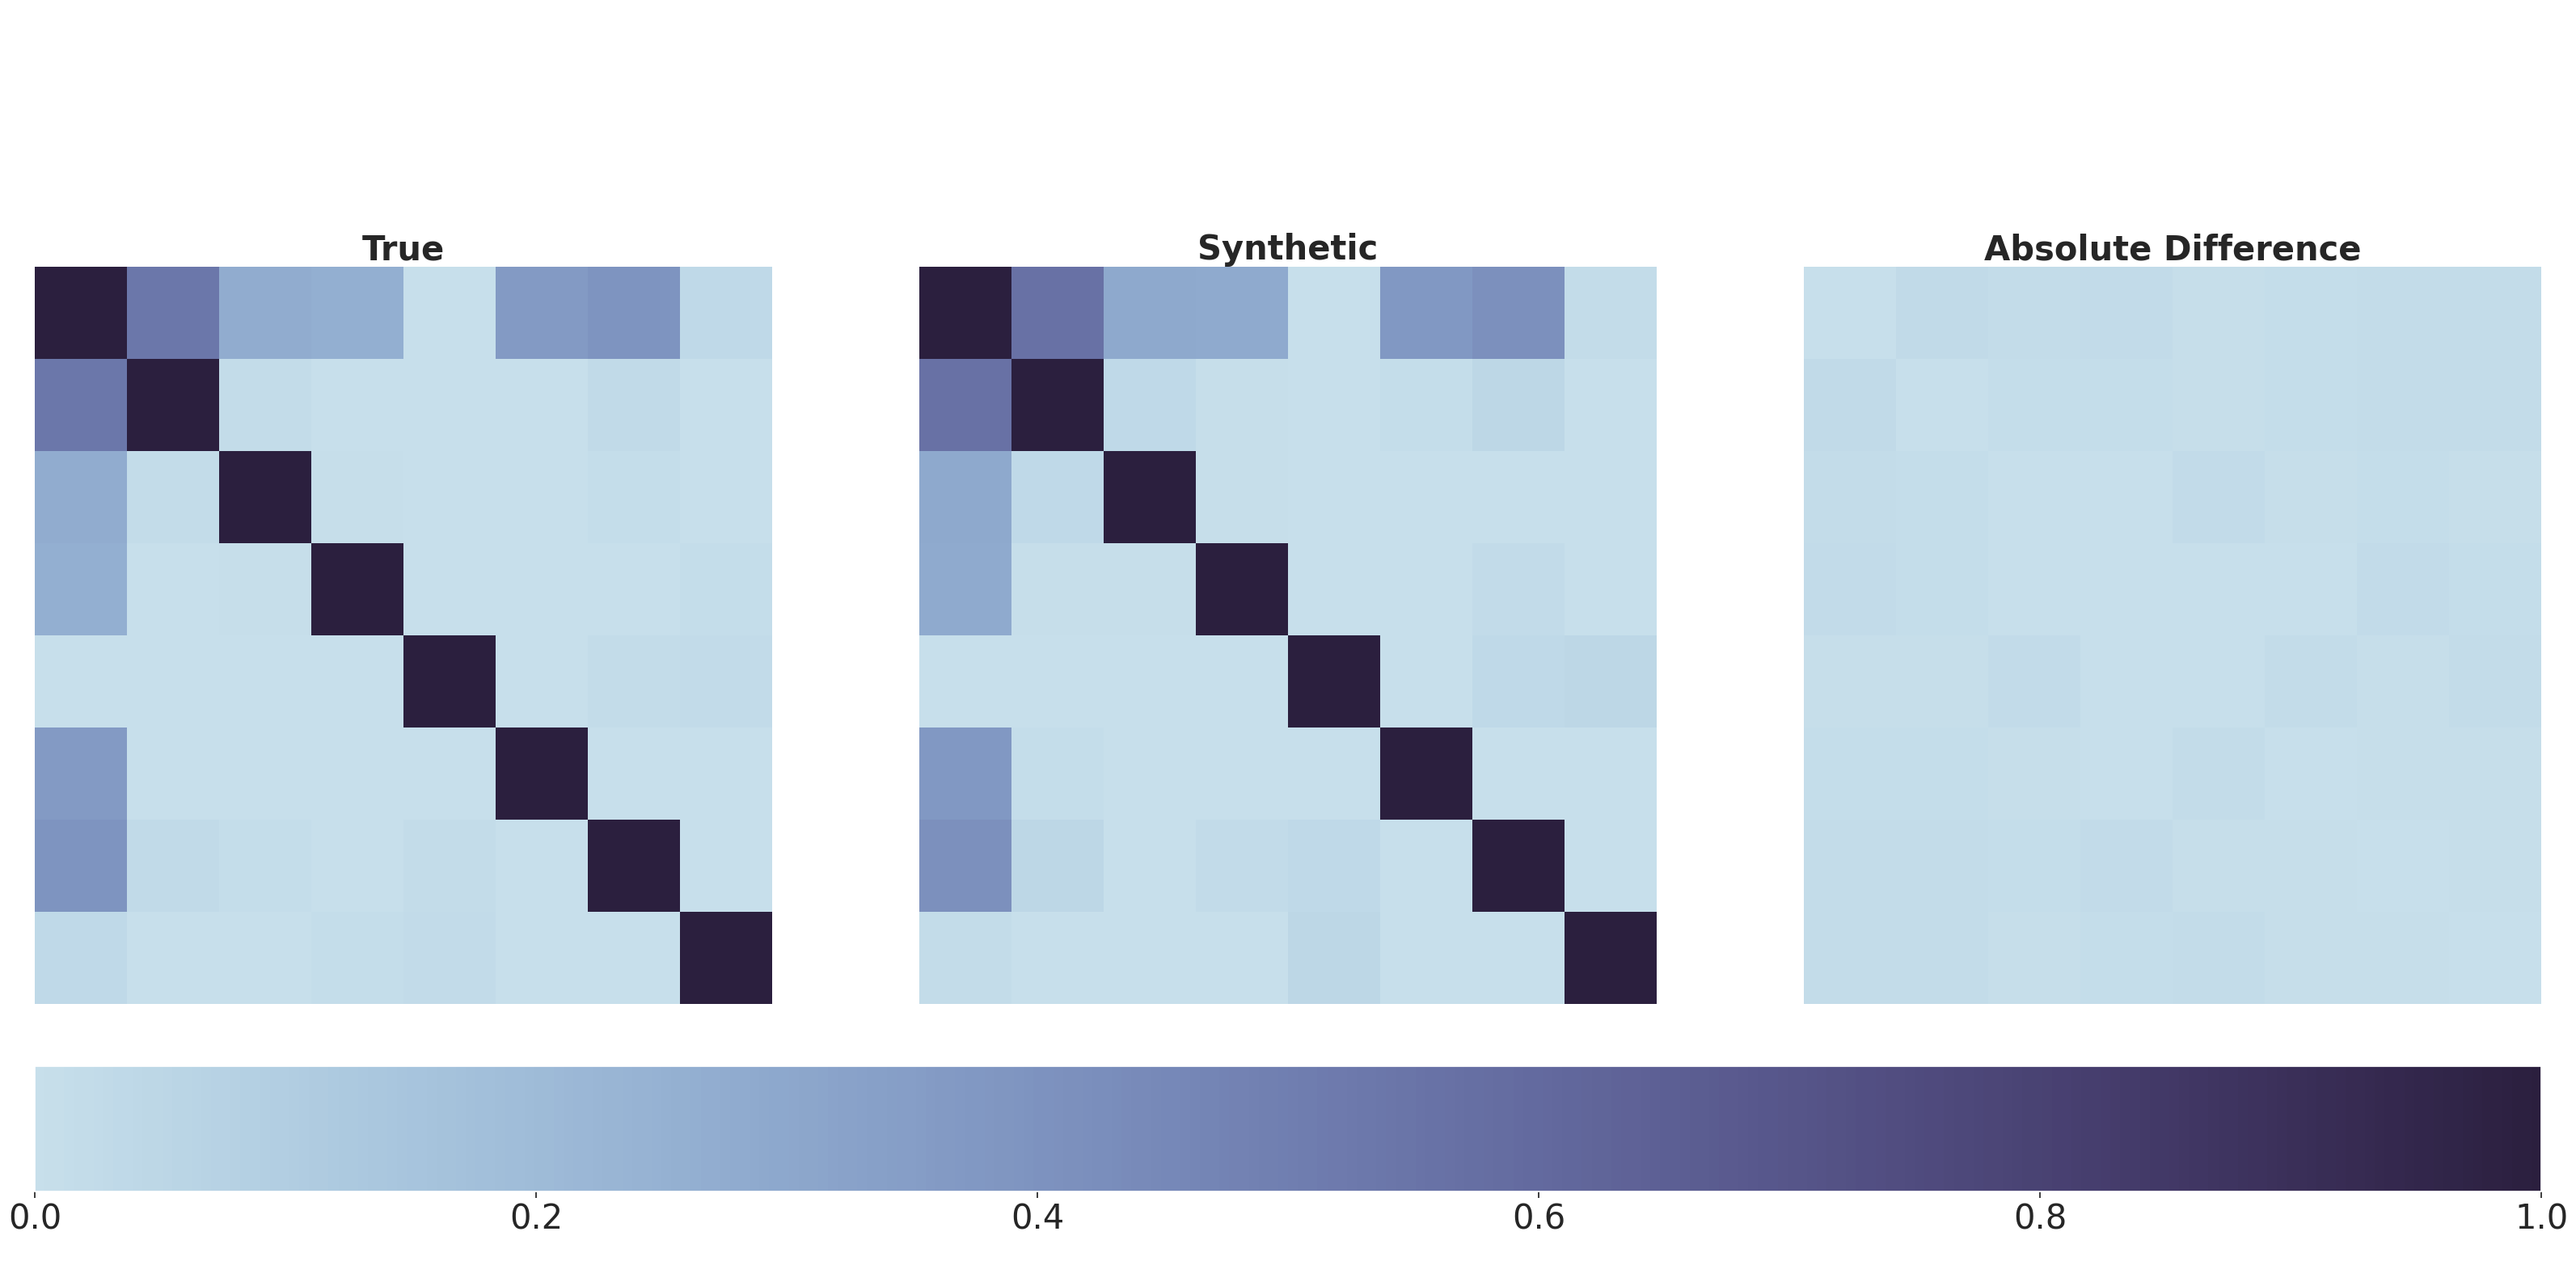

In [6]:
heatmap_correlation(true_df, synthetic_df, "True", "Synthetic")


## Study the effect of generation quality on Syn-Boost

Compare four generative models:
- Model pre-trained on dataset of size 5,000
- Model pre-trained on dataset of size 5,000 and fine-tuned on the raw training set
- Model pre-trained on dataset of size 1,000
- Model pre-trained on dataset of size 1,000 and fine-tuned on the raw training set

In [4]:
keyword_small_size = 1000
keyword_large_size = 5000

result_small= pickle.load(open(f"./results/reg_{keyword_small_size}.pkl", "rb"))
result_small_finetuned = pickle.load(open(f"./results/reg_{keyword_small_size}_finetuned.pkl", "rb"))
result_large = pickle.load(open(f"./results/reg_{keyword_large_size}.pkl", "rb"))
result_large_finetuned = pickle.load(open(f"./results/reg_{keyword_large_size}_finetuned.pkl", "rb"))

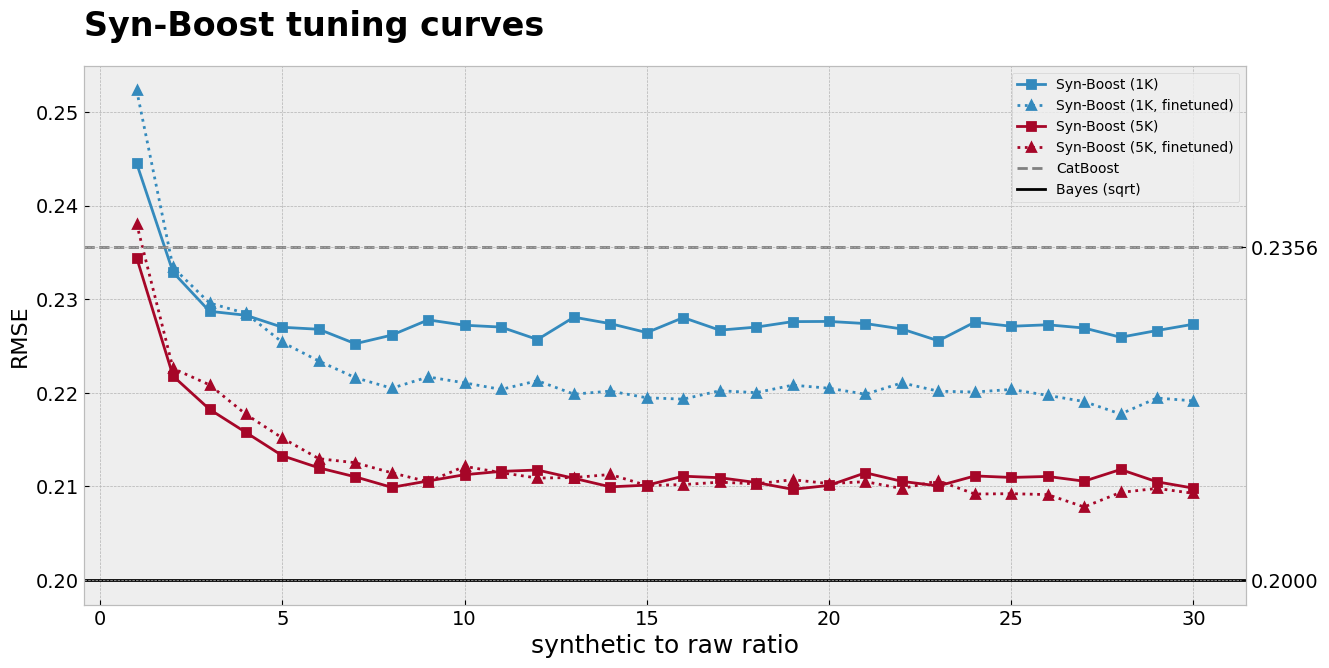

In [6]:
plt.style.use("bmh")


fig, ax = plt.subplots(figsize=(15, 7))

scatter_kargs = {
    "mew": 2,
    "markersize": 6,
    "linewidth": 2,
}

ax.plot(
    result_small["rhos"],
    result_small["scores"],
    color="C0",
    marker="s",
    linestyle="-",
    label=f"Syn-Boost ({round(keyword_small_size/1000)}K)",
    **scatter_kargs,
)

ax.plot(
    result_small_finetuned["rhos"],
    result_small_finetuned["scores"],
    color="C0",
    marker="^",
    linestyle=":",
    label=f"Syn-Boost ({round(keyword_small_size/1000)}K, finetuned)",
    **scatter_kargs,
)

ax.plot(
    result_large["rhos"],
    result_large["scores"],
    color="C1",
    marker="s",
    linestyle="-",
    label=f"Syn-Boost ({round(keyword_large_size/1000)}K)",
    **scatter_kargs,
)

ax.plot(
    result_large_finetuned["rhos"],
    result_large_finetuned["scores"],
    color="C1",
    marker="^",
    linestyle=":",
    label=f"Syn-Boost ({round(keyword_large_size/1000)}K, finetuned)",
    **scatter_kargs,
)


base_line_value = 0.2356
bayes_value = 0.2

y_min, y_max = ax.get_ylim()
y_min = min(
    base_line_value,
    bayes_value,
    min(result_small["scores"]),
    min(result_small_finetuned["scores"]),
    min(result_large["scores"]),
    min(result_large_finetuned["scores"]),
)
y_max = max(
    base_line_value,
    bayes_value,
    max(result_small["scores"]),
    max(result_small_finetuned["scores"]),
    max(result_large["scores"]),
    max(result_large_finetuned["scores"]),
)
y_min, y_max = y_min - 0.05 * (y_max - y_min), y_max + 0.05 * (y_max - y_min)
ax.set_ylim(y_min, y_max)

ax2 = ax.twinx()
ax2.set_yticks([base_line_value, bayes_value])

ax.tick_params(axis="both", which="major", labelsize=14)
ax2.set_ylim(ax.get_ylim())
ax2.tick_params(axis="both", which="major", labelsize=14)


ax.axhline(base_line_value, linestyle="--", color="grey", label="CatBoost")
ax.axhline(bayes_value, linestyle="-", color="black", label="Bayes (sqrt)")


ax.set_xlabel("synthetic to raw ratio", fontsize=18)
ax.set_ylabel("RMSE", fontsize=16)
ax.set_title(
    "Syn-Boost tuning curves",
    weight="bold",
    fontsize=24,
    loc="left",
    y=1.04,
)

ax.legend()

plt.show()